In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import xarray as xr
import pickle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac_all =  ftcw['rel'] 

tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%

cp4_precip_hist = ftcw['prcp_hist']

ltag = ''

In [4]:
np.median(tcwvfac_all)

1.272594179096442

In [5]:
shearfac

0.795388088560751

In [6]:
print(fshear.keys())
print(ftcw.keys())

dict_keys(['obs_shear', 'cp4_shear'])
dict_keys(['rel', 'abs', 'futslope', 'histslope', 'futinter', 'histinter', 'tcw_hist', 'prcp_hist', 'tcw_fut', 'prcp_fut'])


In [7]:
base = '/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/'

dics = ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut']
cp4_read = {'period' : [], 'shear' : [], 'tcwv' : []}
for dd in dics:
   
    dic = pd.read_csv(base+dd+'_vars_DAILY'+ltag+'.csv', index_col=0)

    cp4_read['period'].append(dd)
    cp4_read['shear'].append(np.array(dic.loc['shear']))
    cp4_read['tcwv'].append(np.array(dic.loc['tcwv']))


In [8]:
cp4_read

{'period': ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut'],
 'shear': [array([14.079528]),
  array([17.035107]),
  array([14.019726]),
  array([15.662306])],
 'tcwv': [array([39.5364]),
  array([59.78151]),
  array([39.878483]),
  array([60.606594])]}

In [9]:
cp4_df = pd.DataFrame.from_dict(cp4_read)
cp4_df = cp4_df.set_index('period')

In [10]:
cp4_df.loc['CP25fut','shear']

array([15.662306])

In [11]:
cp4_df.loc['CP25hist','shear']

array([14.019726])

In [12]:
cp4_shear_diff = (cp4_df.loc['CP4fut', 'shear']-cp4_df.loc['CP4hist', 'shear'])#/cp4_df.loc['CP4hist', 'shear']*100
cp25_shear_diff = (cp4_df.loc['CP25fut', 'shear']-cp4_df.loc['CP25hist', 'shear'])#/cp4_df.loc['CP25hist', 'shear']*100

cp4_tcwv_diff = (cp4_df.loc['CP4fut', 'tcwv']-cp4_df.loc['CP4hist', 'tcwv'])/cp4_df.loc['CP4hist', 'tcwv']
cp25_tcwv_diff = (cp4_df.loc['CP25fut', 'tcwv']-cp4_df.loc['CP25hist', 'tcwv'])/cp4_df.loc['CP25hist', 'tcwv']

cp4_historical_domainMean = cp4_df.loc['CP4hist', 'tcwv']
cp4_future_domainMean = cp4_df.loc['CP4fut', 'tcwv']

In [13]:
cp4_historical_domainMean

array([39.5364])

In [14]:
cp4_future_domainMean-cp4_historical_domainMean

array([20.24511])

In [15]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip_read = {}
for dd in dics:
    cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP'+ltag+'.csv', index_col='model_name')
#     (cmip_read[dd[1]])['shear_mean_precip'] = (cmip_read[dd[1]])['shear_mean'] 
#     (cmip_read[dd[1]])['tcw_mean_precip'] = (cmip_read[dd[1]])['tcwv_mean'] 
#     (cmip_read[dd[1]])['shear_perc_'] = (cmip_read[dd[1]])['tcwv_mean'] 

In [16]:
cmip_read['2040']

,Unnamed: 0,shear_mean,tcw_mean,tcw_hist,shear_hist
model_name,,,,,
CESM1-CAM5,0,0.436410,6.638055,42.785386,14.220584
CESM1-BGC,1,0.691756,5.765145,37.317704,13.081765
GISS-E2-R-CC,2,1.144176,5.883850,42.508641,14.398726
IPSL-CM5A-LR,3,0.591262,8.214066,30.679255,12.633809
GFDL-ESM2M,4,0.142381,6.494601,42.941644,8.922368
NorESM1-M,5,1.520915,6.347375,31.675741,9.705886
MPI-ESM-LR,6,1.034984,7.073482,40.817246,13.602209
HadGEM2-CC,7,2.341832,8.132132,28.964960,9.737091
GISS-E2-R,8,0.989110,6.021357,42.511328,14.544476


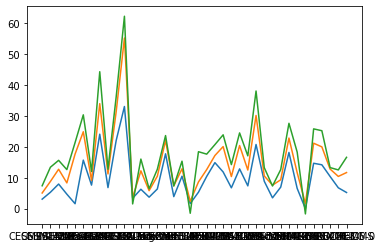

In [17]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['shear_mean']/((cmip_read[y])['shear_hist'])*100)

33.98344259329927
50.265267455263626
68.58373185819308


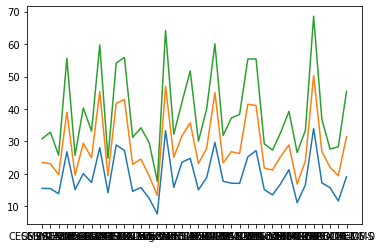

In [32]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['tcw_mean']/((cmip_read[y])['tcw_hist'])*100)
    print(np.max(cmip_read[y]['tcw_mean']/((cmip_read[y])['tcw_hist'])*100))

11.784634907133956
17.430777468864292
23.783177301670484


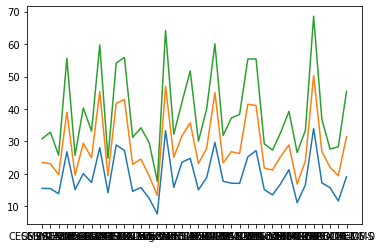

In [33]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['tcw_mean']/((cmip_read[y])['tcw_hist'])*100)
    print(np.max((cmip_read[y]['tcw_mean']+(cmip_read[y])['tcw_hist'])-((cmip_read[y])['tcw_hist'])))

In [ ]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['tcw_mean']+((cmip_read[y])['tcw_hist']))

In [20]:
np.percentile(cmip_read[y]['tcw_mean']/((cmip_read[y])['tcw_hist']),90)

0.5703801581509201

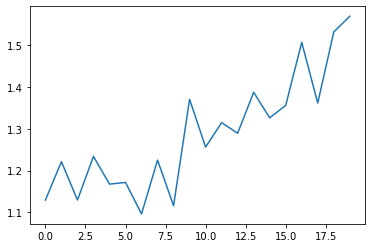

In [21]:
plt.plot(tcwvfac_all)

In [22]:
np.median(tcwvfac_all)

1.272594179096442

In [23]:
len(tcwvfac_all)

20

In [24]:
np.sort(tcwvfac_all)[11]

1.3146242376665924

10,90 perc tcw model bcc-csm1-1 HadGEM2-CC
Shear 10,90 0.3993226789136145 1.404543678280458
TCW 10, 90 9.73137296310281 20.29068028551469
mean 1.2878667882390202 40.419306877753776 [2.35083233] [0.05816112]
min 1.096114079515061 32.36138490331091 [2.35083233] [0.07264313]
max 1.5692401551851867 46.054885243647036 [2.35083233] [0.05104415]
10,90 perc tcw model CSIRO-Mk3-6-0 ACCESS1-3
Shear 10,90 0.6486798870493737 1.9694763294802868
TCW 10, 90 14.015816253036327 31.014933109956235
mean 1.2878667882390202 40.419306877753776 [2.35083233] [0.05816112]
min 1.096114079515061 32.36138490331091 [2.35083233] [0.07264313]
max 1.5692401551851867 46.054885243647036 [2.35083233] [0.05104415]
10,90 perc tcw model FIO-ESM ACCESS1-3
Shear 10,90 0.7925428436943186 2.3394347273327996
TCW 10, 90 19.186669790380655 40.39175576823274
mean 1.2878667882390202 40.419306877753776 [2.35083233] [0.05816112]
min 1.096114079515061 32.36138490331091 [2.35083233] [0.07264313]
max 1.5692401551851867 46.05488524364703

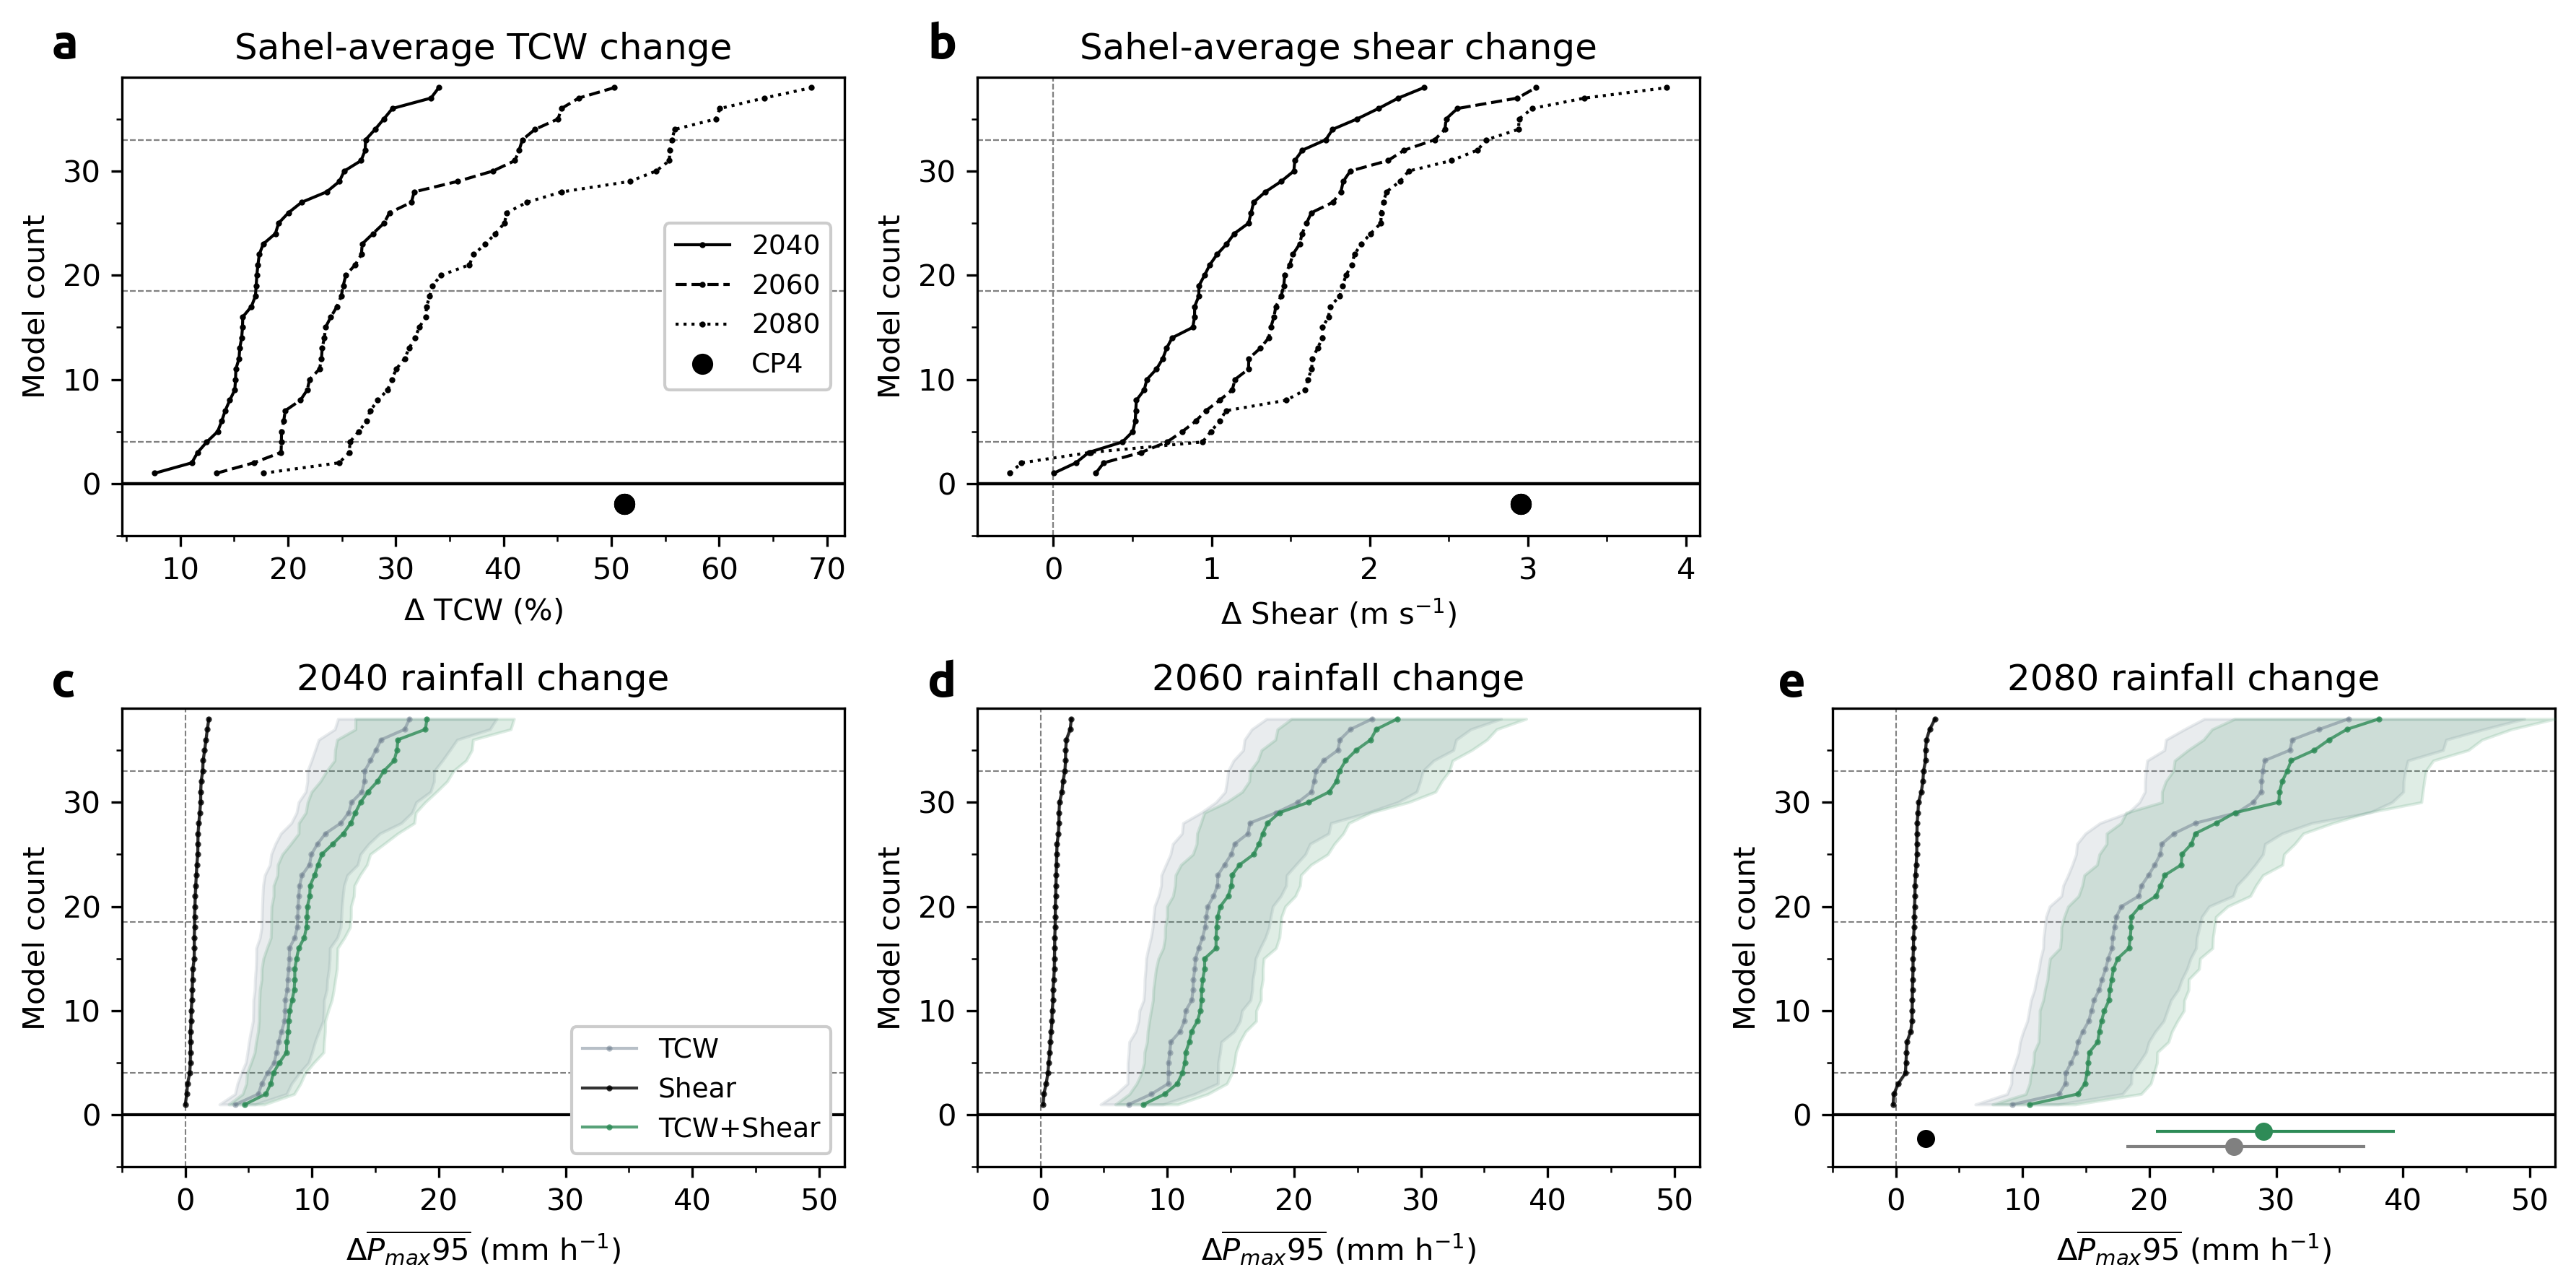

In [42]:
#tcwvfac = tcwvfac_all[np.argmin(np.abs(cp4_historical_domainMean- ftcw['tcw_hist']))] #take tcw scaling for CP4 baseline tcw (37.2 mm domain wide) - it's the average scaling, where lower  
tcwvfac = np.mean(tcwvfac_all)
    
f = plt.figure(figsize=(12,6), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

perc_dic = {}


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = ((cmip_read[stry])['tcw_mean'])/(cmip_read[stry])['tcw_hist'] *100
    cmean = np.mean(x)
    cumulative = np.sort(x)
    posimean = np.argmin(np.abs(cmean-cumulative))

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)

    ax1.set_title(r'Sahel-average TCW change')
    ax1.set_xlabel('$\Delta$ TCW (%)')  #kg m$^{-2}$
    ax1.set_ylabel('Model count')


    x = (cmip_read[stry])['shear_mean']
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)
    
    ax2.set_title(r'Sahel-average shear change')
    ax2.set_xlabel('$\Delta$ Shear (m s$^{-1}$)')
    ax2.set_ylabel('Model count')
    
    if ids == 2:

       # ax1.plot(cp25_tcwv_diff*100,0.03-shiftfac, color='k', marker='x', label='P25', linestyle='')
        ax1.plot(cp4_tcwv_diff*100,0.03-shiftfac, color='k', marker='o', label='CP4', linestyle='')

      #  ax2.plot(cp25_shear_diff,0.03-shiftfac, color='k', marker='x', label='P25', linestyle='')
        ax2.plot(cp4_shear_diff,0.03-shiftfac, color='k', marker='o', label='CP4', linestyle='')
    else:
        
        shiftfac=2
     #   ax1.plot(cp25_tcwv_diff*100,0.03-shiftfac, color='k', marker='x', linestyle='')
        ax1.plot(cp4_tcwv_diff*100,0.03-shiftfac, color='k', marker='o', linestyle='')

     #   ax2.plot(cp25_shear_diff,0.03-shiftfac, color='k', marker='x',  linestyle='')
        ax2.plot(cp4_shear_diff,0.03-shiftfac, color='k', marker='o',  linestyle='')
        
        
    ax1.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)

    ax1.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axvline(0, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax1.axhline(0, linestyle='solid', lw=1, color='k')
    ax2.axhline(0, linestyle='solid', lw=1, color='k')
    ax1.set_ylim(-5,39)
    ax2.set_ylim(-5,39)
    
    ax1.xaxis.set_minor_locator(MultipleLocator(5))
    ax1.yaxis.set_minor_locator(MultipleLocator(5))
    
    ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(MultipleLocator(5))
    
   # ipdb.set_trace()
    
    
    #########################################
    ########################################
    #########################################
    
    ax = f.add_subplot(2,3,ids+4)
    ##########
    ax.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    fdic = {'min' : [], 'max' : [], 'mean':[]}
    for fag, tcwvfac in zip(['mean','min','max'],[np.mean(tcwvfac_all), np.min(tcwvfac_all), np.max(tcwvfac_all)]):
        
        if fag == 'mean':
            pcphist = np.mean(cp4_precip_hist)
        if fag == 'min':
            pcphist = np.min(cp4_precip_hist)
        if fag == 'max':
            pcphist = np.max(cp4_precip_hist)
        
        x = (cmip_read[stry])['tcw_mean']/(cmip_read[stry])['tcw_hist'] * tcwvfac *100 # /cp4_historical_domainMean * tcwvfac *100 #/(cmip_read[stry])['tcw_hist']) * tcwvfac *100
        cumulative = np.sort(x)  # percentage rainfall increase from relative CMIP change

        order = np.argsort(x)
        mnames = (cmip_read['2040']).index[order]

            
        cmip_p_from_shear = (cmip_read[stry]).shear_mean[order] *shearfac  # absolute rainfall from CMIP shear change
        cmip_p_from_tcw = pcphist*cumulative/100  # 
        cmip_perc_per_mm = cumulative/cmip_p_from_tcw
        cmip_perc_shear = cmip_p_from_shear * cmip_perc_per_mm

#         cmip_shear_ordered = np.sort(cmip_perc_shear)
#         cmip_total_ordered = np.sort(cumulative+cmip_perc_shear)

        cmip_shear_ordered = np.sort(cmip_p_from_shear)
        cmip_total_ordered = np.sort(cmip_p_from_tcw+cmip_p_from_shear)
        cumulative = cmip_p_from_tcw
        
        
        fdic[fag]=(cumulative,cmip_shear_ordered,cmip_total_ordered)

        
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
    print('10,90 perc tcw model', mnames[perc[0]], mnames[perc[-1]])
    perc_dic[stry] = {'tcw': (mnames[perc[0]], mnames[perc[-1]])}
    
    print('Shear 10,90', cmip_shear_ordered[perc[0]], cmip_shear_ordered[perc[-1]])
    print('TCW 10, 90', cmip_p_from_tcw[perc[0]], cmip_p_from_tcw[perc[-1]])
    
    
    ax.plot(fdic['mean'][0], np.arange(len(fdic['mean'][0]))+1, color='slategrey', alpha=0.5, label='TCW', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(fdic['mean'][0]))+1, fdic['min'][0], fdic['max'][0], color='slategrey', alpha=0.15, zorder=99)
    
    ax.plot(fdic['mean'][1], np.arange(len(fdic['mean'][0]))+1, color='k', alpha=0.8, label='Shear', marker='o', markersize=1, zorder=99, linewidth=1) 
    ax.fill_betweenx(np.arange(len(fdic['mean'][1]))+1, fdic['max'][1], fdic['min'][1], color='k', alpha=0.15, zorder=99)
    
    ax.plot(fdic['mean'][2], np.arange(len(fdic['mean'][0]))+1, color='seagreen', alpha=0.8, label='TCW+Shear', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(fdic['mean'][2]))+1, fdic['min'][2], fdic['max'][2], color='seagreen', alpha=0.15, zorder=99)
    #ipdb.set_trace()
#     if stry=='2080':
#         ipdb.set_trace()
    
    ax.axvline(0, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    #ax.axvline(5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(5))

    
    ##############
    fdic4 = {'min' : [], 'max' : [], 'mean':[]}
    fdic25 = {'min' : [], 'max' : [], 'mean':[]}
    for fag, tcwvfac in zip(['mean','min','max'],[np.mean(tcwvfac_all), np.min(tcwvfac_all), np.max(tcwvfac_all)]):
        
        if fag == 'mean':
            pcphist = np.mean(cp4_precip_hist)
        if fag == 'min':
            pcphist = np.min(cp4_precip_hist)
        if fag == 'max':
            pcphist = np.max(cp4_precip_hist)

        
        cp4_perc_tcw = cp4_tcwv_diff * tcwvfac  #/cp4_historical_domainMean
        cp4_p_from_shear = cp4_shear_diff *shearfac
        #ipdb.set_trace()
        cp4_p_from_tcw = cp4_perc_tcw * pcphist
        cp4_perc_per_mm = cp4_perc_tcw/cp4_p_from_tcw
        cp4_perc_shear = cp4_p_from_shear/ pcphist#* cp4_perc_per_mm
        


#         cp25_perc_tcw = cp25_tcwv_diff * tcwvfac  # /cp4_historical_domainMean
#         cp25_p_from_shear = cp25_shear_diff *shearfac
#         cp25_p_from_tcw = cp25_perc_tcw *pcphist 
#         cp25_perc_per_mm = cp25_perc_tcw/cp25_p_from_tcw
#         cp25_perc_shear = cp25_p_from_shear * cp25_perc_per_mm

                    
        print(fag, tcwvfac,pcphist, cp4_p_from_shear, cp4_perc_shear)
        
        fdic4[fag]=(cp4_p_from_tcw,cp4_p_from_shear,cp4_p_from_tcw+cp4_p_from_shear)
        
        #fdic4[fag]=(cp4_perc_tcw,cp4_perc_shear,cp4_perc_tcw+cp4_perc_shear)
#         fdic25[fag]=(cp25_perc_tcw,cp25_perc_shear,cp25_perc_tcw+cp25_perc_shear)
   # ipdb.set_trace()
    mst = 5
    if ids == 2:

        shiftfac = 7
       # ax.errorbar(np.array(fdic25['mean'][0])*100,0.03-shiftfac, xerr=[(fdic25['mean'][0]-fdic25['min'][0])*100, (fdic25['max'][0]-fdic25['mean'][0])*100], color='grey', marker='x', linewidth=1)
        ax.errorbar(fdic4['mean'][0],4-shiftfac,  xerr=[(fdic4['mean'][0]-fdic4['min'][0]), (fdic4['max'][0]-fdic4['mean'][0])],color='grey', marker='o', linewidth=1, ms=mst)
      #  ax.errorbar(fdic25['mean'][1]*100,0.73-shiftfac,  xerr=[(fdic25['mean'][1]-fdic25['min'][1])*100, (fdic25['max'][1]-fdic25['mean'][1])*100],color='k', marker='x', linewidth=1)
        ax.errorbar(fdic4['mean'][1],4.7-shiftfac,  xerr=[(fdic4['mean'][1]-fdic4['max'][1]), (fdic4['min'][1]-fdic4['mean'][1])],color='k', marker='o', linewidth=1, ms=mst)
      #  ax.errorbar(fdic25['mean'][2]*100,1.43-shiftfac,  xerr=[(fdic25['mean'][2]-fdic25['min'][2])*100, (fdic25['max'][2]-fdic25['mean'][2])*100],color='seagreen', marker='x', linewidth=1)
        ax.errorbar(fdic4['mean'][2],5.4-shiftfac,  xerr=[(fdic4['mean'][2]-fdic4['min'][2]), (fdic4['max'][2]-fdic4['mean'][2])],color='seagreen', marker='o', linewidth=1, ms=mst)
       # ipdb.set_trace()
        #ax.errorbar(pcp4f['rbins'], pcp4f['pmean'], xerr=np.array(fdic4['mean'][0]*100-fdic4['mean'][0]*100), color='xkcd:tomato', linewidth=0.5, linestyle='')
   
    plt.xlabel('$\Delta \overline{P_{max}95}$ (mm h$^{-1}$)')
    plt.ylabel('Model count')
    #ax.set_xlim(-5,105)
    ax.set_xlim(-5,52)
    ax.set_ylim(-5,39)
    
    #ipdb.set_trace()

    plt.title(stry +' rainfall change')
    if ids == 0:
        plt.legend(loc='lower right', fontsize=9, framealpha=1)  #facecolor='lightgrey'
ax1.legend(fontsize=9, framealpha=1)
#ax2.legend()

#ipdb.set_trace()
plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.02, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.02, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.69, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_order_Sahel_inclCP4_ABS_hourlyScaling_relToCMIP_9-19N_20masked_0.1mm_minmax.jpg')

10,90 perc tcw model bcc-csm1-1 HadGEM2-CC
mean 1.2878667882390202 40.419306877753776 [2.35083233] [0.05816112]
min 1.1147275415545341 34.48606231429428 [2.35083233] [0.06816761]
max 1.5333231335805235 43.82005087433463 [2.35083233] [0.05364741]
10,90 perc tcw model CSIRO-Mk3-6-0 ACCESS1-3
mean 1.2878667882390202 40.419306877753776 [2.35083233] [0.05816112]
min 1.1147275415545341 34.48606231429428 [2.35083233] [0.06816761]
max 1.5333231335805235 43.82005087433463 [2.35083233] [0.05364741]
10,90 perc tcw model FIO-ESM ACCESS1-3
mean 1.2878667882390202 40.419306877753776 [2.35083233] [0.05816112]
min 1.1147275415545341 34.48606231429428 [2.35083233] [0.06816761]
max 1.5333231335805235 43.82005087433463 [2.35083233] [0.05364741]


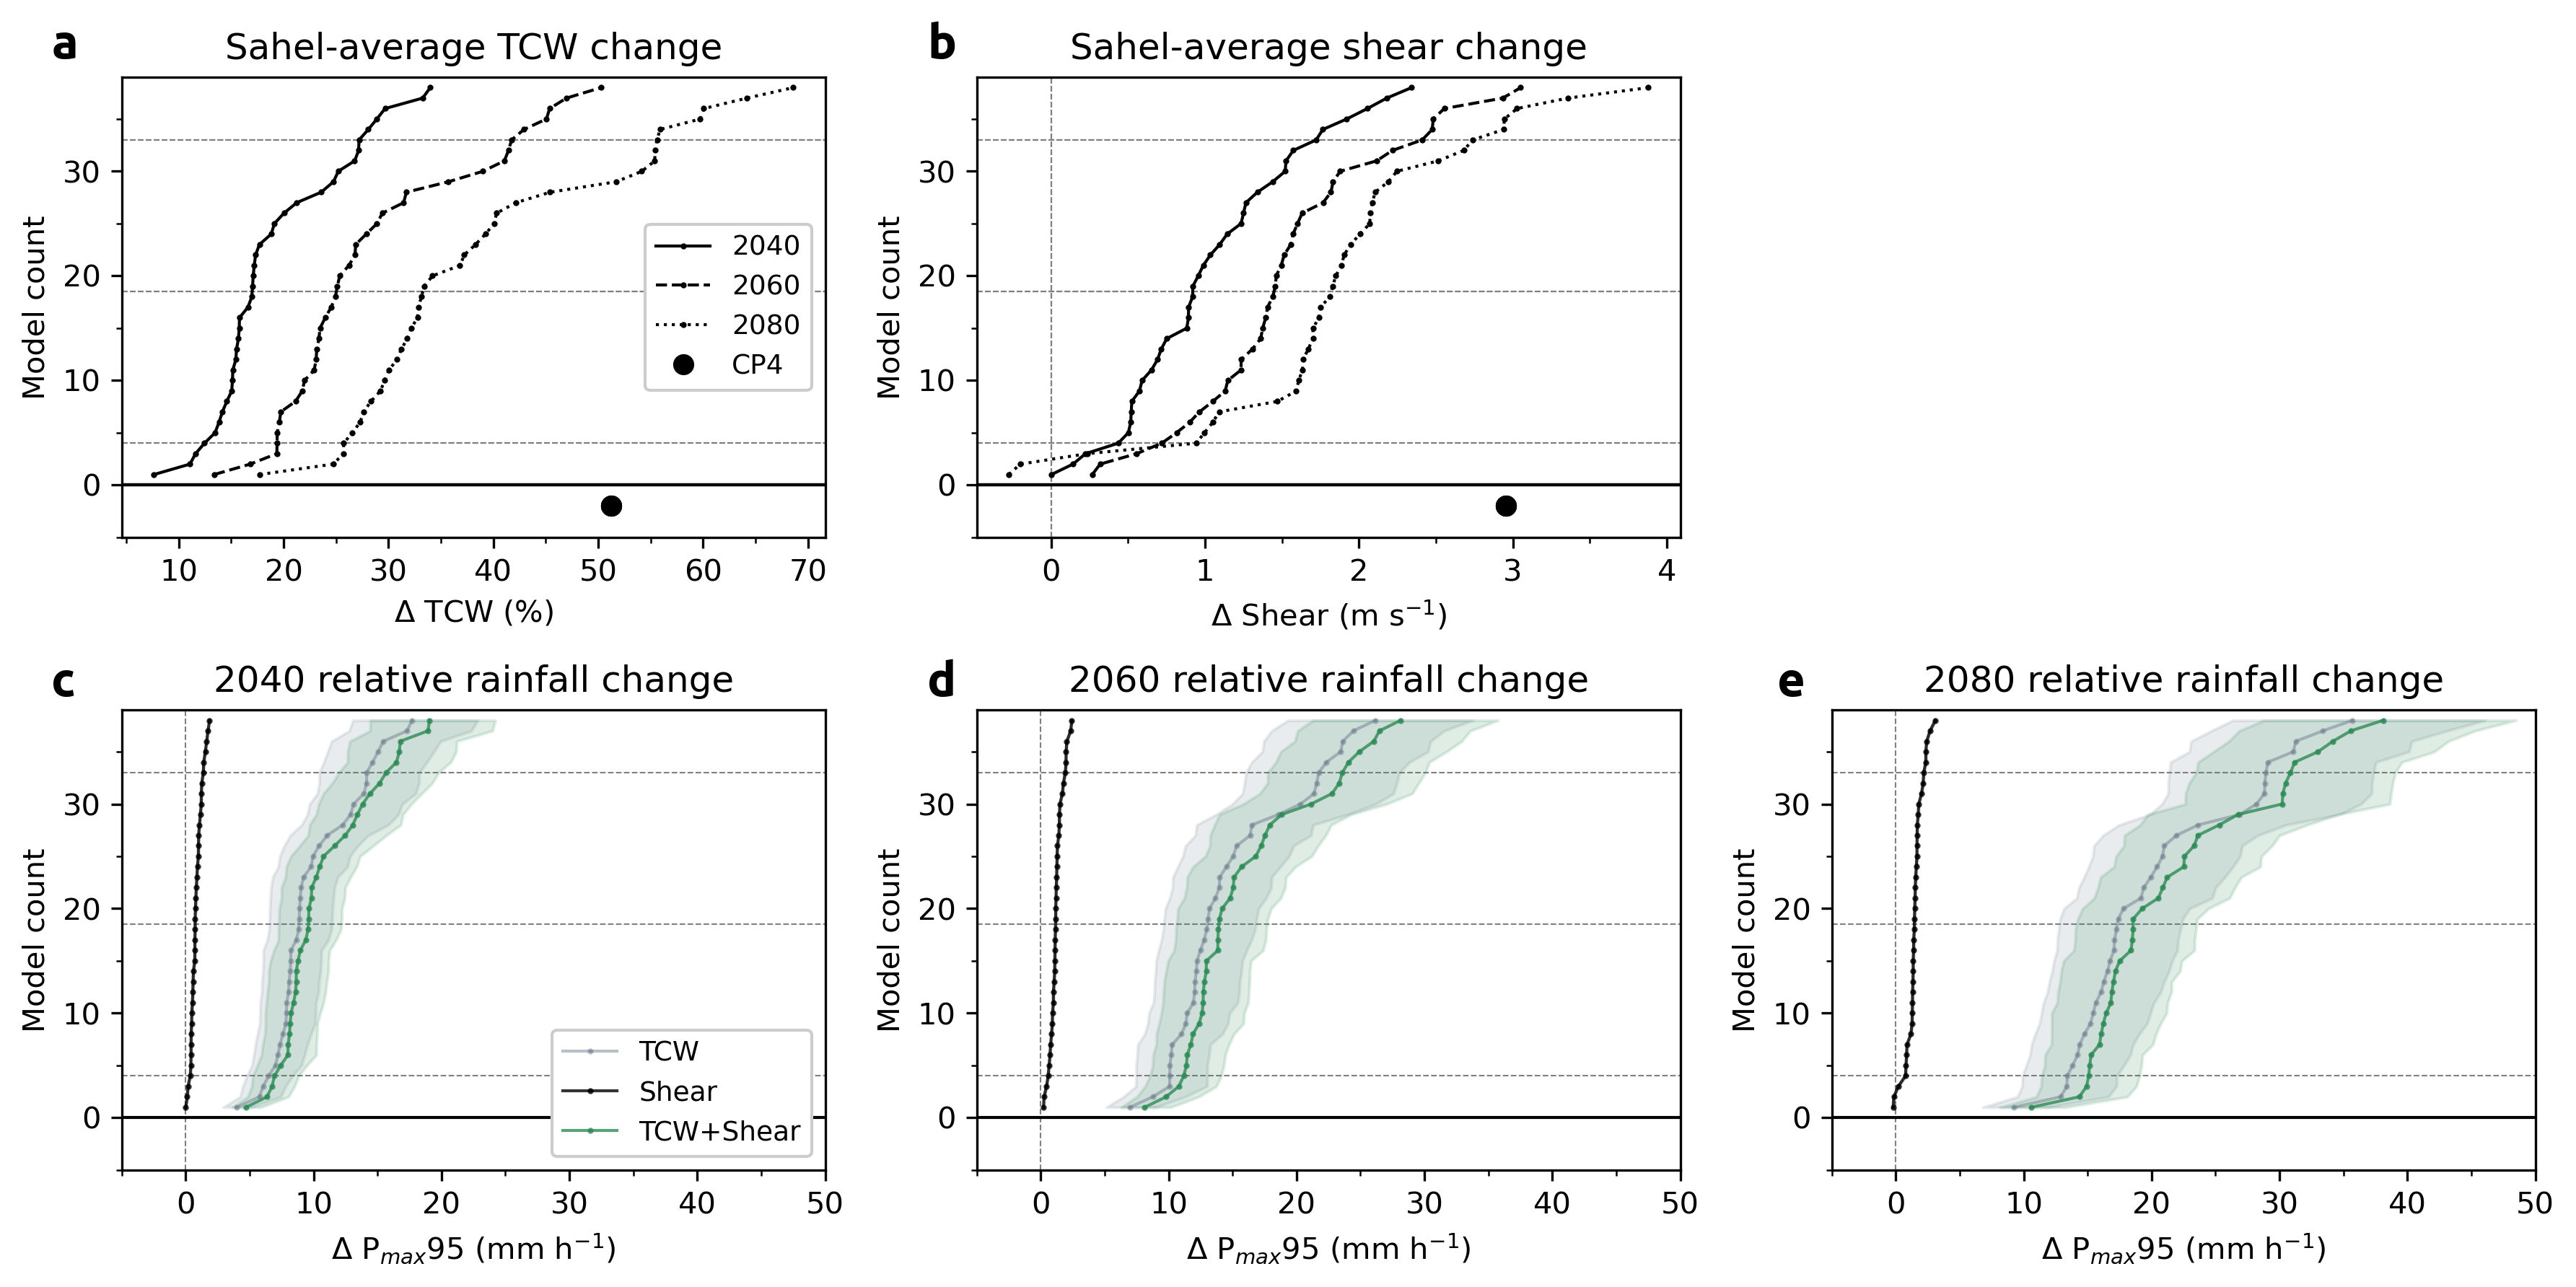

In [27]:
#tcwvfac = tcwvfac_all[np.argmin(np.abs(cp4_historical_domainMean- ftcw['tcw_hist']))] #take tcw scaling for CP4 baseline tcw (37.2 mm domain wide) - it's the average scaling, where lower  
tcwvfac = np.mean(tcwvfac_all)
    
f = plt.figure(figsize=(12,6), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

perc_dic = {}


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = ((cmip_read[stry])['tcw_mean'])/(cmip_read[stry])['tcw_hist'] *100
    cmean = np.mean(x)
    cumulative = np.sort(x)
    posimean = np.argmin(np.abs(cmean-cumulative))

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)

    ax1.set_title(r'Sahel-average TCW change')
    ax1.set_xlabel('$\Delta$ TCW (%)')  #kg m$^{-2}$
    ax1.set_ylabel('Model count')


    x = (cmip_read[stry])['shear_mean']
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)
    
    ax2.set_title(r'Sahel-average shear change')
    ax2.set_xlabel('$\Delta$ Shear (m s$^{-1}$)')
    ax2.set_ylabel('Model count')
    
    if ids == 2:

       # ax1.plot(cp25_tcwv_diff*100,0.03-shiftfac, color='k', marker='x', label='P25', linestyle='')
        ax1.plot(cp4_tcwv_diff*100,0.03-shiftfac, color='k', marker='o', label='CP4', linestyle='')

      #  ax2.plot(cp25_shear_diff,0.03-shiftfac, color='k', marker='x', label='P25', linestyle='')
        ax2.plot(cp4_shear_diff,0.03-shiftfac, color='k', marker='o', label='CP4', linestyle='')
    else:
        
        shiftfac=2
     #   ax1.plot(cp25_tcwv_diff*100,0.03-shiftfac, color='k', marker='x', linestyle='')
        ax1.plot(cp4_tcwv_diff*100,0.03-shiftfac, color='k', marker='o', linestyle='')

     #   ax2.plot(cp25_shear_diff,0.03-shiftfac, color='k', marker='x',  linestyle='')
        ax2.plot(cp4_shear_diff,0.03-shiftfac, color='k', marker='o',  linestyle='')
        
        
    ax1.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)

    ax1.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axvline(0, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax1.axhline(0, linestyle='solid', lw=1, color='k')
    ax2.axhline(0, linestyle='solid', lw=1, color='k')
    ax1.set_ylim(-5,39)
    ax2.set_ylim(-5,39)
    
    ax1.xaxis.set_minor_locator(MultipleLocator(5))
    ax1.yaxis.set_minor_locator(MultipleLocator(5))
    
    ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(MultipleLocator(5))
    
   # ipdb.set_trace()
    
    
    #########################################
    ########################################
    #########################################
    
    ax = f.add_subplot(2,3,ids+4)
    ##########
    ax.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    fdic = {'min' : [], 'max' : [], 'mean':[]}
    for fag, tcwvfac in zip(['mean','min','max'],[np.mean(tcwvfac_all), np.percentile(tcwvfac_all,5), np.percentile(tcwvfac_all,95)]):
        
        if fag == 'mean':
            pcphist = np.mean(cp4_precip_hist)
        if fag == 'min':
            pcphist = np.percentile(cp4_precip_hist,5)
        if fag == 'max':
            pcphist = np.percentile(cp4_precip_hist,95)
        
        x = (cmip_read[stry])['tcw_mean']/(cmip_read[stry])['tcw_hist'] * tcwvfac *100 # /cp4_historical_domainMean * tcwvfac *100 #/(cmip_read[stry])['tcw_hist']) * tcwvfac *100
        cumulative = np.sort(x)  # percentage rainfall increase from relative CMIP change

        order = np.argsort(x)
        mnames = (cmip_read['2040']).index[order]

            
        cmip_p_from_shear = (cmip_read[stry]).shear_mean[order] *shearfac  # absolute rainfall from CMIP shear change
        cmip_p_from_tcw = pcphist*cumulative/100  # 
        cmip_perc_per_mm = cumulative/cmip_p_from_tcw
        cmip_perc_shear = cmip_p_from_shear * cmip_perc_per_mm

#         cmip_shear_ordered = np.sort(cmip_perc_shear)
#         cmip_total_ordered = np.sort(cumulative+cmip_perc_shear)

        cmip_shear_ordered = np.sort(cmip_p_from_shear)
        cmip_total_ordered = np.sort(cmip_p_from_tcw+cmip_p_from_shear)
        cumulative = cmip_p_from_tcw
        
        
        fdic[fag]=(cumulative,cmip_shear_ordered,cmip_total_ordered)

        
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
    print('10,90 perc tcw model', mnames[perc[0]], mnames[perc[-1]])
    perc_dic[stry] = {'tcw': (mnames[perc[0]], mnames[perc[-1]])}
   
    ax.plot(fdic['mean'][0], np.arange(len(fdic['mean'][0]))+1, color='slategrey', alpha=0.5, label='TCW', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(fdic['mean'][0]))+1, fdic['min'][0], fdic['max'][0], color='slategrey', alpha=0.15, zorder=99)
    
    ax.plot(fdic['mean'][1], np.arange(len(fdic['mean'][0]))+1, color='k', alpha=0.8, label='Shear', marker='o', markersize=1, zorder=99, linewidth=1) 
    ax.fill_betweenx(np.arange(len(fdic['mean'][1]))+1, fdic['max'][1], fdic['min'][1], color='k', alpha=0.15, zorder=99)
    
    ax.plot(fdic['mean'][2], np.arange(len(fdic['mean'][0]))+1, color='seagreen', alpha=0.8, label='TCW+Shear', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(fdic['mean'][2]))+1, fdic['min'][2], fdic['max'][2], color='seagreen', alpha=0.15, zorder=99)
    #ipdb.set_trace()
#     if stry=='2080':
#         ipdb.set_trace()
    
    ax.axvline(0, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    #ax.axvline(5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(5))

    
    ##############
    fdic4 = {'min' : [], 'max' : [], 'mean':[]}
    fdic25 = {'min' : [], 'max' : [], 'mean':[]}
    for fag, tcwvfac in zip(['mean','min','max'],[np.mean(tcwvfac_all), np.percentile(tcwvfac_all,5), np.percentile(tcwvfac_all,95)]):
        
        if fag == 'mean':
            pcphist = np.mean(cp4_precip_hist)
        if fag == 'min':
            pcphist = np.percentile(cp4_precip_hist,5)
        if fag == 'max':
            pcphist = np.percentile(cp4_precip_hist,95)

        
        cp4_perc_tcw = cp4_tcwv_diff * tcwvfac  #/cp4_historical_domainMean
        cp4_p_from_shear = cp4_shear_diff *shearfac
        #ipdb.set_trace()
        cp4_p_from_tcw = cp4_perc_tcw * pcphist
        cp4_perc_per_mm = cp4_perc_tcw/cp4_p_from_tcw
        cp4_perc_shear = cp4_p_from_shear/ pcphist#* cp4_perc_per_mm
        


#         cp25_perc_tcw = cp25_tcwv_diff * tcwvfac  # /cp4_historical_domainMean
#         cp25_p_from_shear = cp25_shear_diff *shearfac
#         cp25_p_from_tcw = cp25_perc_tcw *pcphist 
#         cp25_perc_per_mm = cp25_perc_tcw/cp25_p_from_tcw
#         cp25_perc_shear = cp25_p_from_shear * cp25_perc_per_mm

                    
        print(fag, tcwvfac,pcphist, cp4_p_from_shear, cp4_perc_shear)
        
        fdic4[fag]=(cp4_p_from_tcw,cp4_p_from_shear,cp4_p_from_tcw+cp4_p_from_shear)
        
        #fdic4[fag]=(cp4_perc_tcw,cp4_perc_shear,cp4_perc_tcw+cp4_perc_shear)
#         fdic25[fag]=(cp25_perc_tcw,cp25_perc_shear,cp25_perc_tcw+cp25_perc_shear)
  #  ipdb.set_trace()
    mst = 5
    if ids == 2:

        shiftfac = 7
       # ax.errorbar(np.array(fdic25['mean'][0])*100,0.03-shiftfac, xerr=[(fdic25['mean'][0]-fdic25['min'][0])*100, (fdic25['max'][0]-fdic25['mean'][0])*100], color='grey', marker='x', linewidth=1)
        ax.errorbar(fdic4['mean'][0]*100,4-shiftfac,  xerr=[(fdic4['mean'][0]-fdic4['min'][0])*100, (fdic4['max'][0]-fdic4['mean'][0])*100],color='grey', marker='o', linewidth=1, ms=mst)
      #  ax.errorbar(fdic25['mean'][1]*100,0.73-shiftfac,  xerr=[(fdic25['mean'][1]-fdic25['min'][1])*100, (fdic25['max'][1]-fdic25['mean'][1])*100],color='k', marker='x', linewidth=1)
        ax.errorbar(fdic4['mean'][1]*100,4.7-shiftfac,  xerr=[(fdic4['mean'][1]-fdic4['max'][1])*100, (fdic4['min'][1]-fdic4['mean'][1])*100],color='k', marker='o', linewidth=1, ms=mst)
      #  ax.errorbar(fdic25['mean'][2]*100,1.43-shiftfac,  xerr=[(fdic25['mean'][2]-fdic25['min'][2])*100, (fdic25['max'][2]-fdic25['mean'][2])*100],color='seagreen', marker='x', linewidth=1)
        ax.errorbar(fdic4['mean'][2]*100,5.4-shiftfac,  xerr=[(fdic4['mean'][2]-fdic4['min'][2])*100, (fdic4['max'][2]-fdic4['mean'][2])*100],color='seagreen', marker='o', linewidth=1, ms=mst)
       # ipdb.set_trace()
        #ax.errorbar(pcp4f['rbins'], pcp4f['pmean'], xerr=np.array(fdic4['mean'][0]*100-fdic4['mean'][0]*100), color='xkcd:tomato', linewidth=0.5, linestyle='')
   
    plt.xlabel('$\Delta$ P$_{max}95$ (mm h$^{-1}$)')
    plt.ylabel('Model count')
    #ax.set_xlim(-5,105)
    ax.set_xlim(-5,50)
    ax.set_ylim(-5,39)
    
    #ipdb.set_trace()

    plt.title(stry +' relative rainfall change')
    if ids == 0:
        plt.legend(loc='lower right', fontsize=9, framealpha=1)  #facecolor='lightgrey'
ax1.legend(fontsize=9, framealpha=1)
#ax2.legend()

#ipdb.set_trace()
plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.02, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.02, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.69, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_order_Sahel_inclCP4_ABS_hourlyScaling_relToCMIP_9-19N_20masked_0.1mm_5-95p.jpg')

In [27]:
pkl.dump(perc_dic, open('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CMIPpercentiles_1090_Sahel_tcwShear.p', "wb"))

In [28]:
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

NameError: name 'mmPerPercent' is not defined

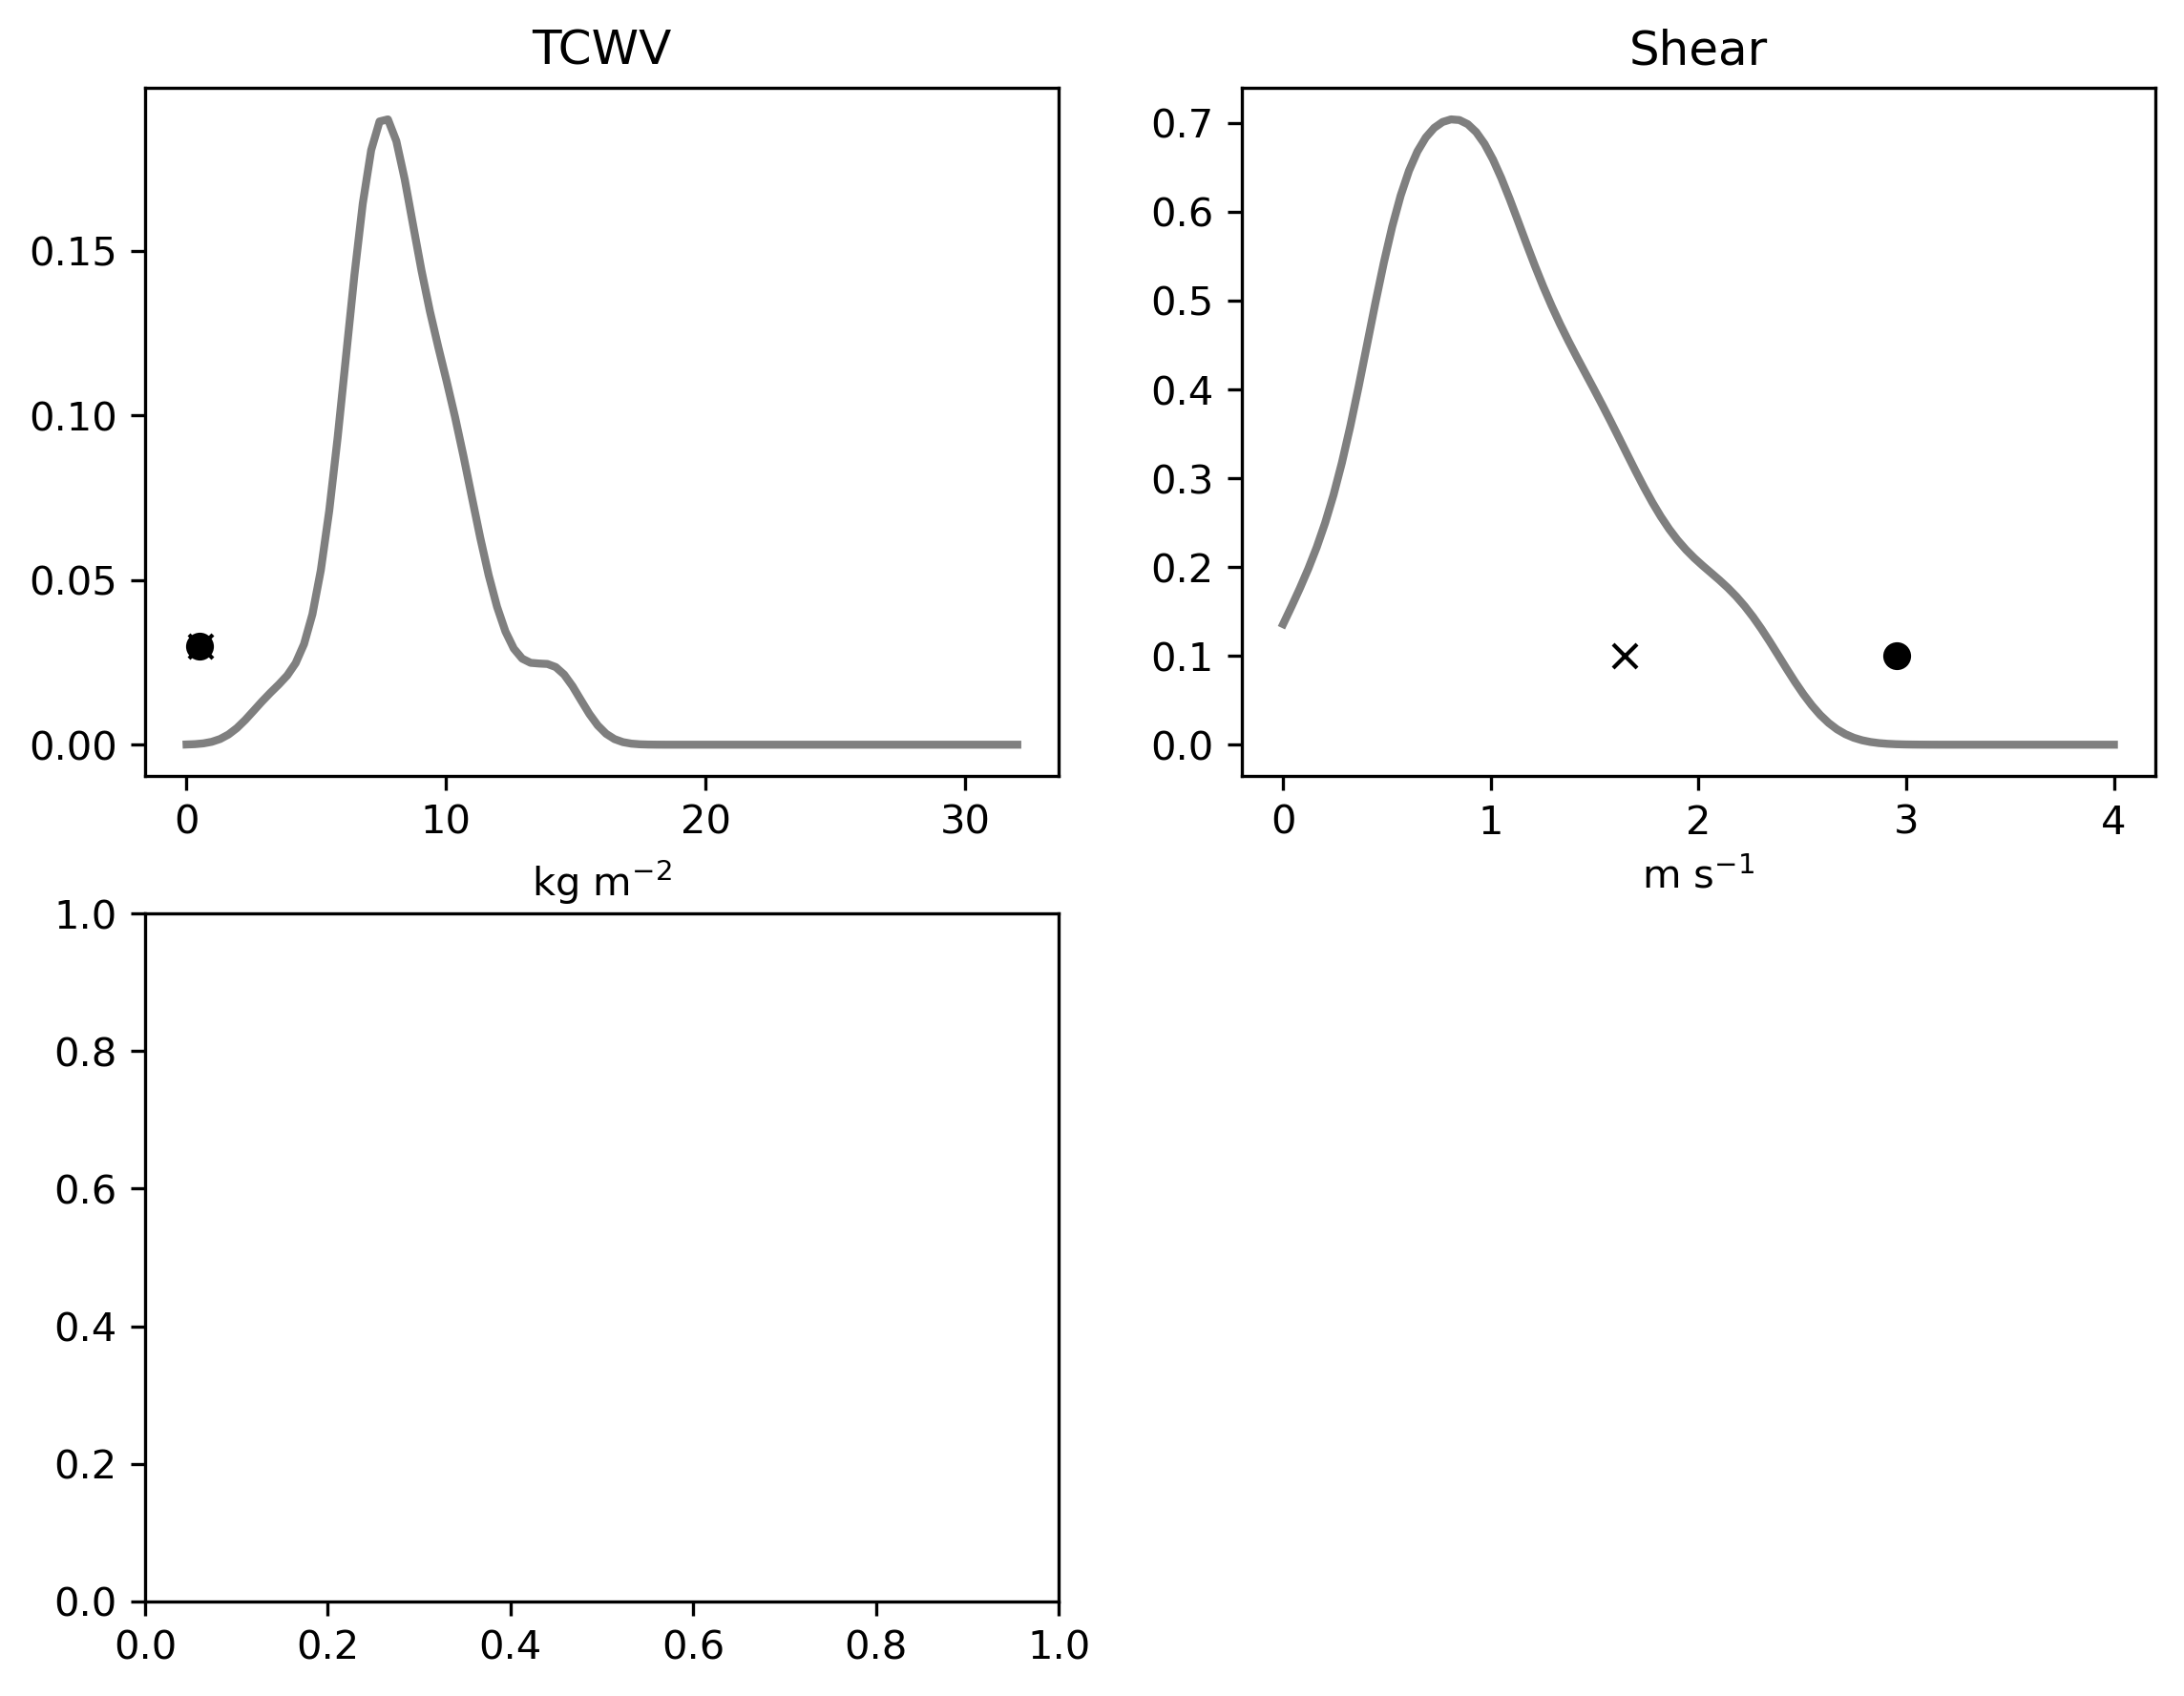

In [29]:

f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########

    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac
    x_grid = np.linspace(0, 32, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1)
    ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    #ax1.axvline(0, linestyle='dashed', lw=1)
    
#     if ids == 2:
#         x = cmip_sahel_tcw.values[np.isfinite(cmip_sahel_tcw.values)]
#         x_grid = np.linspace(0, 25, 100)
#         pdf = kde_scipy(x, x_grid, bandwidth=1)
#         ax1.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
#         ax1.set_title('TCWV')
#         ax1.set_xlabel('kg m$^{-2}$')
#         #ax1.axvline(0, linestyle='dashed', lw=1)
        
    
    
    #
    x = (cmip_read[stry])['shear_mean']
    x_grid = np.linspace(0, 4, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=0.2)
    ax2.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    #plt.axvline(0, linestyle='dashed', lw=1)
    
#     if ids == 2:
        
#         x = cmip_sahel_sh.values[np.isfinite(cmip_sahel_sh.values)]
#         x_grid = np.linspace(-3, 1, 100)
#         pdf = kde_scipy(x, x_grid, bandwidth=0.2)
#         ax2.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
#         ax2.set_title('Shear')
#         ax2.set_xlabel('m s$^{-1}$')
#         #plt.axvline(0, linestyle='dashed', lw=1)
        
    ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x')
    ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o')
    #ax1.plot(cp4_sahel_tcw, 0.03, color='grey', marker='o')
    ax2.plot(cp25_shear_diff,0.1, color='k', marker='x')
    ax2.plot(cp4_shear_diff,0.1, color='k', marker='o')
    #ax2.plot(cp4_sahel_shear, 0.03, color='grey', marker='o')
        

    ax = f.add_subplot(2,3,ids+4)
    ##########
    #tcplot = hist2d.basic_1d_binning(cmip_tc_perc['2080'].values, np.arange(np.min(cmip_tc_perc['2080']), np.max(cmip_tc_perc['2080']),1))
    #ax.bar(tcplot['xbins'], tcplot['nb']/np.sum(tcplot['nb']), color='grey', label='TCWV')

    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac  / mmPerPercent
    x_grid = np.linspace(0, 85, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='slategrey', alpha=0.5, lw=2, label='TCWV')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = ((cmip_read[stry])['shear_mean']) * shearfac / mmPerPercent
    x_grid = np.linspace(0, 10, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='k', alpha=0.8, lw=2, label='Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = (((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * tcabsfac) / mmPerPercent
    x_grid = np.linspace(0, 85, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
#     if ids == 2:
#         ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.01, color='grey', marker='x')
#         ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.01, color='grey', marker='o')
#         ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.01, color='k', marker='x')
#         ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='k', marker='o')
#         ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.01, color='seagreen', marker='x')
#         ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='seagreen', marker='o')
        
    if ids == 2:
        ax.plot(cp25_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='x')
        ax.plot(cp4_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='o')
        ax.plot(cp25_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='x')
        ax.plot(cp4_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='o')
        ax.plot((cp25_shear_diff * shearfac +  cp25_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='x')
        ax.plot((cp4_shear_diff * shearfac +  cp4_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='o')

    plt.xlabel('%')
    plt.ylabel('Density')

    plt.title(stry)

    plt.legend()
ax1.legend()
ax2.legend()
plt.tight_layout()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_PDF_Sahelonly.png')

In [ ]:
f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

mk=3
linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = cmip_tc_diff[stry].values[np.isfinite(cmip_tc_diff[stry].values)]
    cumulative = np.sort(x)

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    #ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    ax1.set_ylabel('Model number')

    ax1.plot(cp4_diff.loc['tcw', 'R25DELTA'],0.03, color='k', marker='x')
    ax1.plot(cp4_diff.loc['tcw', 'CP4DELTA'],0.03, color='k', marker='o')
    ax2.plot(cp4_diff.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
    ax2.plot(cp4_diff.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')

    #ax1.axvline(0, linestyle='dashed', lw=1)
    
    
    #
    x = cmip_sh_diff[stry].values[np.isfinite(cmip_sh_diff[stry].values)]
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    ax2.set_ylabel('Model number')
    #plt.axvline(0, linestyle='dashed', lw=1)

    ax = f.add_subplot(2,3,ids+4)
    ##########
    x = cmip_tc_perc[stry].values[np.isfinite(cmip_tc_perc[stry].values)]
    cumulative = np.sort(x)

    ax.plot(cumulative, np.arange(len(cumulative))+1, color='slategrey', alpha=0.5, lw=2, label='TCWV', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = cmip_sh_perc[stry].values[np.isfinite(cmip_sh_perc[stry].values)]
    cumulative = np.sort(x)
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='k', alpha=0.8, lw=2, label='Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = cmip_shtc_precip[stry].values[np.isfinite(cmip_shtc_precip[stry].values)]
    cumulative = np.sort(x)
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
    if ids == 2:
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.03, color='grey', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.03, color='grey', marker='o')
        ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
        ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.03, color='seagreen', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='seagreen', marker='o')
   
    plt.xlabel('%')
    plt.ylabel('Model number')

    plt.title(stry)
    if ids == 0:
        plt.legend()
ax1.legend()
#ax2.legend()

#ipdb.set_trace()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_marker+uncertainty.png')

In [ ]:
start = 1
nums = []
nums.append(start)
for ix in range(len(np.arange(15,65))):
    start = start+start*0.07
    nums.append(start)
    

In [ ]:
plt.plot(np.arange(15,66), nums,'or')

In [ ]:
x = np.arange(15,56)
y = np.array(nums)

In [ ]:
y[1::]-y[0:-1]

In [ ]:
(y[5]-y[1])/y[1]

In [ ]:
(y[35]-y[25])/y[25]

In [ ]:
(y[25]-y[15])/y[15]

In [ ]:
(x[10+a]-x[1+a])